In [1]:
# Import required libraries
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from core.backtest_orchestrator import BacktestOrchestrator
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✅ Imports successful")
print(f"   Project root: {project_root}")

✅ Imports successful
   Project root: /Users/Sakarias/QuantTrading


## 1. Portfolio Configuration

Define portfolio-level settings. This CONFIG dictionary controls:
- **assets**: Which instruments to trade
- **total_capital**: Total portfolio capital (for capital_pct allocation)
- **oos_split**: Out-of-sample percentage (e.g., 0.20 = 80% train, 20% test)
- **date_range**: Backtest period
- **use_futures_sizing**: Whether to use integer contract sizing

In [2]:
# Portfolio Configuration
CONFIG = {
    'assets': ['ES', 'NQ'],  # S&P 500 and Nasdaq futures
    'total_capital': 500_000,  # $500k portfolio
    'oos_split': 0.20,  # 80% train, 20% out-of-sample
    'date_range': ('2015-01-01', '2024-12-31'),  # 5 years
    'use_futures_sizing': False  # Set True for futures contract sizing
}

print("📋 Portfolio Configuration:")
print(f"   Assets: {CONFIG['assets']}")
print(f"   Total Capital: ${CONFIG['total_capital']:,}")
print(f"   Train/Test Split: {(1-CONFIG['oos_split'])*100:.0f}% / {CONFIG['oos_split']*100:.0f}%")
print(f"   Date Range: {CONFIG['date_range'][0]} to {CONFIG['date_range'][1]}")

📋 Portfolio Configuration:
   Assets: ['ES', 'NQ']
   Total Capital: $500,000
   Train/Test Split: 80% / 20%
   Date Range: 2015-01-01 to 2024-12-31


## 2. Initialize Orchestrator & Load Data

Create the orchestrator with our config and load price data.

In [3]:
# Initialize orchestrator with config
orchestrator = BacktestOrchestrator(config=CONFIG)

# Load data for all assets
orchestrator.load_data(
    tickers=CONFIG['assets'],
    start_date=CONFIG['date_range'][0],
    end_date=CONFIG['date_range'][1],
    use_yfinance=True,
    verbose=True
)

# Optional: Load benchmark for comparison
orchestrator.load_benchmark('SPY', verbose=True)

📊 Loading data for 2 assets...

Loading 2 assets: ['ES', 'NQ']
  📡 CSV data is 338 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-12-04)
✓ ES: 6362 rows, 2000-09-18 to 2025-12-04
  📡 CSV data is 338 days old, fetching recent data from yfinance...
  ✓ Added 228 days from yfinance (now through 2025-12-04)
✓ NQ: 6362 rows, 2000-09-18 to 2025-12-04

Common date range: 2000-09-18 to 2025-12-04
Filtered date range: 2015-01-01 to 2024-12-31

Total unique dates: 2515

ALIGNMENT SUMMARY
ES: 2515/2515 valid dates (100.0%)
NQ: 2515/2515 valid dates (100.0%)

✅ Data loaded successfully:
   ES: 2515 days (2015-01-02 to 2024-12-31)
      Price range: $1824.50 - $6099.00
   NQ: 2515 days (2015-01-02 to 2024-12-31)
      Price range: $3944.25 - $22110.25

📈 Loading benchmark: SPY...
📥 Updating SPY benchmark data...
  ✓ Added 228 days from yfinance (now through 2025-12-04)
✓ ES: 6362 rows, 2000-09-18 to 2025-12-04
  📡 CSV data is 338 days old, fetchin

## 3. Split Train/Test Data

Split data into in-sample (train) and out-of-sample (test) periods.
This is crucial for preventing overfitting!

The split uses the `oos_split` percentage from CONFIG.

In [4]:
# Split data: 80% train, 20% OOS
orchestrator.split_train_test_data(verbose=True)

print("\n📊 Data split complete!")
print(f"   In-sample: {len(orchestrator.prices_train['ES'])} days")
print(f"   Out-of-sample: {len(orchestrator.prices_test['ES'])} days")


📊 Splitting data: 80% train, 20% OOS
  ES: 2012 train days, 503 test days
      Train: 2015-01-02 to 2022-12-30
      Test:  2023-01-03 to 2024-12-31
  NQ: 2012 train days, 503 test days
      Train: 2015-01-02 to 2022-12-30
      Test:  2023-01-03 to 2024-12-31
✅ Data split complete. Use .prices for train, .prices_test for OOS

📊 Data split complete!
   In-sample: 2012 days
   Out-of-sample: 503 days


## 4. Define Strategies

Add strategies interactively with:
- **name**: Strategy identifier
- **signal_generator**: Signal class instance
- **assets**: Which assets this strategy trades
- **capital_pct**: Percentage of total_capital (auto-validates ≤ 100%)
- **position_sizer_type**: Sizing method ('fixed', 'atr', 'volatility', 'kelly', 'futures')
- **risk_per_trade**: Risk per trade (default: 0.02 = 2%)

### Available Position Sizers:
- **'fixed'**: Fixed fractional (risk-based)
- **'atr'**: ATR-based volatility sizing
- **'volatility'**: Inverse volatility weighting
- **'kelly'**: Kelly Criterion
- **'futures'**: Integer contract sizing

**⚠️ Important:** If you get an allocation error when rerunning this cell, you need to reinitialize the orchestrator (rerun cells 2-4) or clear the strategies first.

In [5]:
# Strategy 1: Momentum on ES (40% of capital)
orchestrator.add_strategy(
    name='Momentum_ES',
    signal_generator=MomentumSignalV2(lookback=20, entry_threshold=0.02),
    assets=['ES'],
    capital_pct=0.40,  # 40% = $200k
    position_sizer_type='fixed',
    risk_per_trade=0.06  # 2% risk per trade
)

# Strategy 2: Mean Reversion on NQ (60% of capital)
orchestrator.add_strategy(
    name='MeanReversion_NQ',
    signal_generator=MeanReversionSignal(window=30, entry_z=2.0, exit_z=0.5),
    assets=['NQ'],
    capital_pct=0.60,  # 60% = $300k
    position_sizer_type='fixed',
    risk_per_trade=0.06
)

print("\n✅ Strategies configured successfully!")
print(f"   Total allocated: {orchestrator.allocated_capital:.1%} of capital")


✅ Strategies configured successfully!
   Total allocated: 100.0% of capital


## 5. Generate Signals (In-Sample)

Generate trading signals on the training data.

In [6]:
# Generate signals for all strategies
orchestrator.generate_signals(verbose=True)


🎯 Generating signals for 2 strategies...

  Momentum_ES (MomentumSignalV2):
    ES: 92.9% long, 0.0% short, 7.1% flat

  MeanReversion_NQ (MeanReversionSignal):
    NQ: 13.2% long, 24.6% short, 62.2% flat

✅ Signals generated successfully
    NQ: 13.2% long, 24.6% short, 62.2% flat

✅ Signals generated successfully


## 6. Run In-Sample Backtests

Execute backtests on the training period.

In [7]:
# Run backtests
results = orchestrator.run_backtests(verbose=True)


🔄 Running backtests for 2 strategies...

  Momentum_ES ($200,000.0)...
    ✅ Total Return: 83.53%
    📊 Sharpe: 0.40
    📉 Max DD: -34.42%

  MeanReversion_NQ ($300,000.0)...
    ✅ Total Return: 65.92%
    📊 Sharpe: 0.38
    📉 Max DD: -21.43%

✅ All backtests completed successfully


## 7. In-Sample Results

View detailed results for the training period.

In [8]:
# Print formatted summary
orchestrator.print_summary()


📊 BACKTEST SUMMARY
        Strategy   Capital Assets  Final Value  Total Return  CAGR  Sharpe  Max Drawdown  Win Rate  Total Trades
     Momentum_ES 200000.00     ES    367052.67          0.84  0.08    0.40         -0.34      0.00             0
MeanReversion_NQ 300000.00     NQ    497747.37          0.66  0.07    0.38         -0.21      0.77            26

----------------------------------------------------------------------------------------------------
Portfolio Total Capital: $500,000
Portfolio Final Value:   $864,800
Portfolio Return:        72.96%


In [9]:
# Get summary DataFrame for further analysis
summary_df = orchestrator.get_summary()
print("\n📊 Detailed Metrics:")
print(summary_df.to_string(index=False))


📊 Detailed Metrics:
        Strategy   Capital Assets  Final Value  Total Return  CAGR  Sharpe  Max Drawdown  Win Rate  Total Trades
     Momentum_ES 200000.00     ES    367052.67          0.84  0.08    0.40         -0.34      0.00             0
MeanReversion_NQ 300000.00     NQ    497747.37          0.66  0.07    0.38         -0.21      0.77            26


## 8. Visualize In-Sample Performance

Plot equity curves and benchmark comparison.

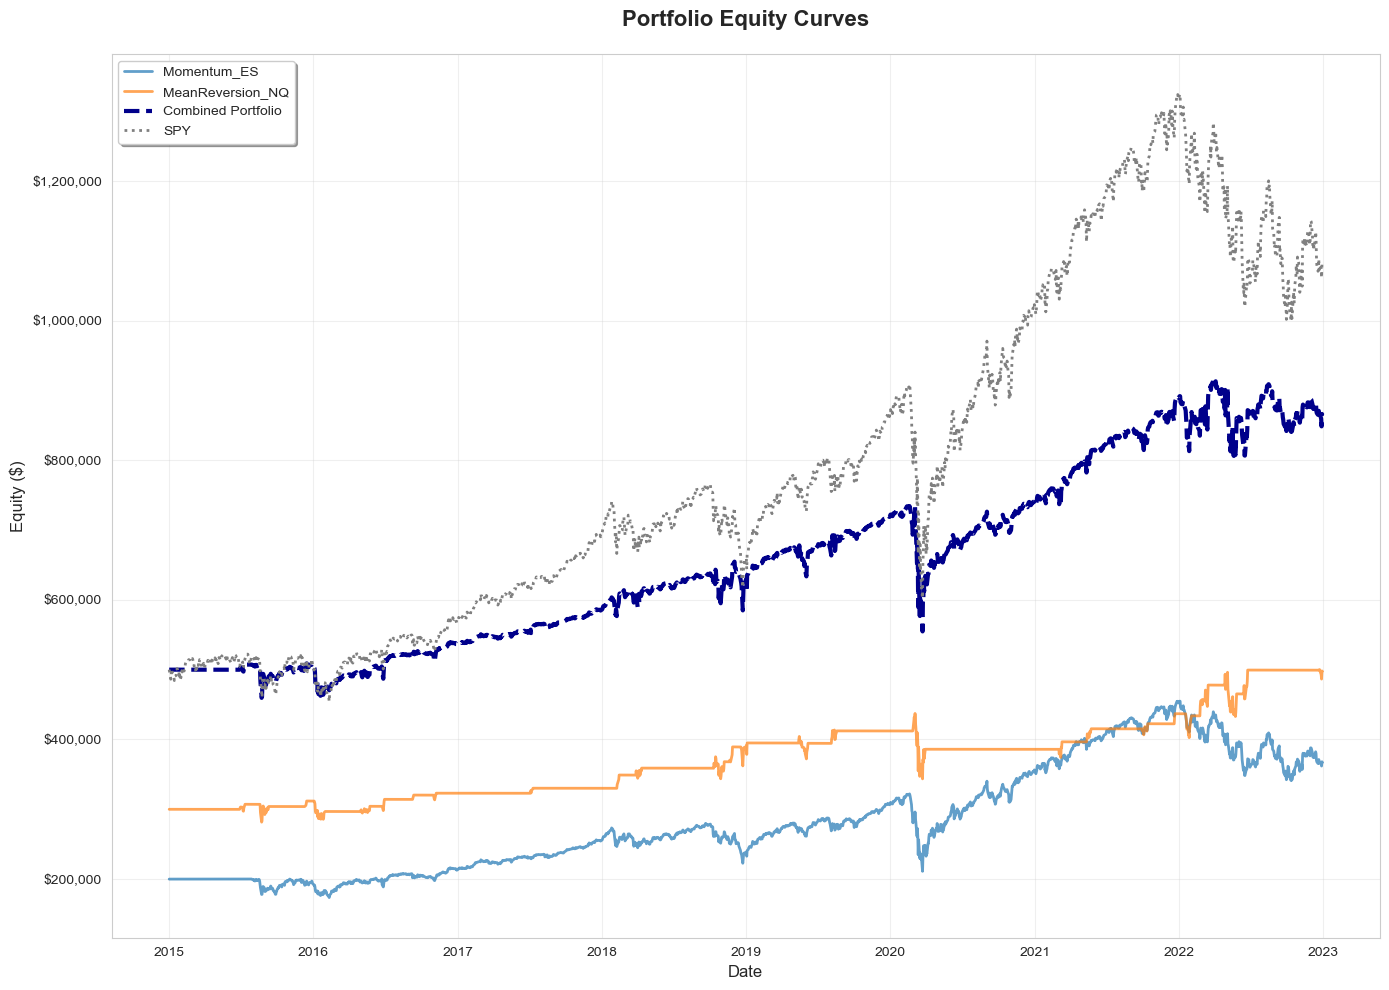

In [10]:
# Plot equity curves
orchestrator.plot_results(
    show_individual=True,
    show_benchmark=True,
    figsize=(14, 10)
)
plt.show()

## 9. Out-of-Sample Validation 🎯

Now test on the held-out OOS data to validate the strategy.
This is the TRUE test of whether the strategy will work in live trading!

In [11]:
# Run OOS backtest
oos_results = orchestrator.run_oos_backtest(verbose=True)

print("\n" + "="*80)
print("📊 OUT-OF-SAMPLE COMPARISON")
print("="*80)

# Compare In-Sample vs OOS
for name in orchestrator.results.keys():
    is_result = orchestrator.results[name]['result']
    oos_result = orchestrator.oos_results[name]['result']
    
    print(f"\n{name}:")
    print(f"   In-Sample Return:  {is_result.total_return:>8.2%}")
    print(f"   OOS Return:        {oos_result.total_return:>8.2%}")
    print(f"   ")
    print(f"   In-Sample Sharpe:  {is_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   OOS Sharpe:        {oos_result.metrics['Sharpe Ratio']:>8.2f}")
    print(f"   ")
    print(f"   In-Sample Max DD:  {is_result.metrics['Max Drawdown']:>8.2%}")
    print(f"   OOS Max DD:        {oos_result.metrics['Max Drawdown']:>8.2%}")

print("\n" + "="*80)


🎯 Running OUT-OF-SAMPLE backtests...

  Momentum_ES - Generating OOS signals...

  MeanReversion_NQ - Generating OOS signals...

  Momentum_ES ($200,000.0)...
    ✅ OOS Return: 34.08%
    📊 OOS Sharpe: 1.20
    📉 OOS Max DD: -10.28%

  MeanReversion_NQ ($300,000.0)...
    ✅ OOS Return: 8.34%
    📊 OOS Sharpe: 0.33
    📉 OOS Max DD: -7.88%

✅ OOS backtests completed

📊 OUT-OF-SAMPLE COMPARISON

Momentum_ES:
   In-Sample Return:    83.53%
   OOS Return:          34.08%
   
   In-Sample Sharpe:      0.40
   OOS Sharpe:            1.20
   
   In-Sample Max DD:   -34.42%
   OOS Max DD:         -10.28%

MeanReversion_NQ:
   In-Sample Return:    65.92%
   OOS Return:           8.34%
   
   In-Sample Sharpe:      0.38
   OOS Sharpe:            0.33
   
   In-Sample Max DD:   -21.43%
   OOS Max DD:          -7.88%



## 10. Export HTML Dashboard

Generate a professional HTML report with all results.

In [12]:
# Export HTML dashboard with OOS results
filepath = orchestrator.export_html_dashboard(
    output_dir='results/html',
    filename_prefix='backtest',
    include_oos=True
)

print(f"\n✅ Dashboard exported to: {filepath}")
print(f"   Open in browser to view full report")


💾 HTML dashboard saved: results/html/backtest_2025-12-04.html

✅ Dashboard exported to: results/html/backtest_2025-12-04.html
   Open in browser to view full report


## 11. Key Takeaways & Next Steps

### Interpretation Guidelines:

**Good Signs:**
- ✅ OOS performance within 70-80% of in-sample
- ✅ Positive Sharpe ratio in both periods
- ✅ Consistent drawdown patterns
- ✅ Similar trade frequency

**Red Flags:**
- ⚠️ OOS much worse than in-sample → Overfitting
- ⚠️ Negative OOS returns → Strategy doesn't work
- ⚠️ Dramatically different metrics → Unstable strategy

### Next Steps:

1. **If OOS looks good:** Consider walk-forward optimization to test across multiple periods
2. **If OOS is weak:** Adjust parameters, try different signals, or simplify strategy
3. **Before going live:** Test on more recent data, check for regime changes
4. **Paper trading:** Always paper trade before risking real capital!

### Advanced Analysis:

- Try different position sizers ('atr', 'volatility', 'kelly')
- Adjust capital allocation percentages
- Test on different assets
- Run walk-forward validation (see `template_walkforward.ipynb`)

## Additional Notes

This template demonstrates:
- ✅ Config-based portfolio setup
- ✅ Percentage-based capital allocation
- ✅ Multiple strategies on different assets
- ✅ In-sample training
- ✅ Out-of-sample validation
- ✅ Automated HTML export

